## Multi-class text classification using BERT

In [ ]:
%pip install torch torchvision

In [ ]:
%pip install --upgrade transformers

In [4]:
import os
import pandas as pd
import numpy as np
import shutil
import sys
import tqdm.notebook as tq
from collections import defaultdict

import torch
import torch.nn as nn

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [6]:
import numpy as np
import json
import csv

df = pd.read_csv('/content/drive/MyDrive/GDSC/Sollution_Challenge/df_osdg_updated.csv')
df

,text,sdg
0,"From a gender perspective, Paulgaard points ou...",5
1,Labour legislation regulates maximum working h...,11
2,The average figure also masks large difference...,3
3,Applied research is directed “primarily toward...,9
4,The extent to which they are akin to corruptio...,3
...,...,...
43730,"UNFF11 Discusses Implementation, Finance and P...",17
43731,FfD 3 Co-Facilitators Announce Additional Cons...,17
43732,High-level Consultation Agrees on FfD Action P...,17
43733,Civil Society Discusses Positioning of UN Deve...,17


In [7]:
df_grouped = df.groupby('sdg').head(1100)

df = pd.concat([df_group for _, df_group in df_grouped.groupby('sdg')], ignore_index=True)
df 

,text,sdg
0,Although the impacts of these imbalances are n...,1
1,Those in the informal sector are often hit har...,1
2,This points to the possibility that the effect...,1
3,"In other words, factors that might make a chil...",1
4,"In Australia, where a broad definition of temp...",1
...,...,...
18695,"UNFF11 Discusses Implementation, Finance and P...",17
18696,FfD 3 Co-Facilitators Announce Additional Cons...,17
18697,High-level Consultation Agrees on FfD Action P...,17
18698,Civil Society Discusses Positioning of UN Deve...,17


In [8]:
# sdg one-hot encoding 
sdg_dummies = pd.get_dummies(df['sdg'], prefix='SDG')

df = pd.concat([df[['text']], sdg_dummies], axis=1)
df

,text,SDG_1,SDG_2,SDG_3,SDG_4,SDG_5,SDG_6,SDG_7,SDG_8,SDG_9,SDG_10,SDG_11,SDG_12,SDG_13,SDG_14,SDG_15,SDG_16,SDG_17
0,Although the impacts of these imbalances are n...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Those in the informal sector are often hit har...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,This points to the possibility that the effect...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,"In other words, factors that might make a chil...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"In Australia, where a broad definition of temp...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18695,"UNFF11 Discusses Implementation, Finance and P...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
18696,FfD 3 Co-Facilitators Announce Additional Cons...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
18697,High-level Consultation Agrees on FfD Action P...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
18698,Civil Society Discusses Positioning of UN Deve...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [9]:
df.head()

,text,SDG_1,SDG_2,SDG_3,SDG_4,SDG_5,SDG_6,SDG_7,SDG_8,SDG_9,SDG_10,SDG_11,SDG_12,SDG_13,SDG_14,SDG_15,SDG_16,SDG_17
0,Although the impacts of these imbalances are n...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Those in the informal sector are often hit har...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,This points to the possibility that the effect...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,"In other words, factors that might make a chil...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"In Australia, where a broad definition of temp...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [10]:
from sklearn.model_selection import train_test_split

# split into train and test
df_train, df_test = train_test_split(df, random_state=77, test_size=0.30, shuffle=True)
# split test into test and validation datasets
df_test, df_valid = train_test_split(df_test, random_state=88, test_size=0.50, shuffle=True)

In [11]:
print(f"Train: {df_train.shape}, Test: {df_test.shape}, Valid: {df_valid.shape}")

Train: (13090, 18), Test: (2805, 18), Valid: (2805, 18)


In [12]:
# Hyperparameters
MAX_LEN = 256
TRAIN_BATCH_SIZE = 32

VALID_BATCH_SIZE = 32
TEST_BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 1e-05
THRESHOLD = 0.5 # threshold for the sigmoid

In [13]:
from transformers import BertTokenizer, BertModel

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [15]:
# Test the tokenizer
test_text = "We are testing BERT tokenizer."
# generate encodings
encodings = tokenizer.encode_plus(
    test_text,
    add_special_tokens=True,
    max_length=50,
    padding="max_length",
    return_attention_mask=True,
    return_tensors="pt",
    truncation=True  
)
# we get a dictionary with three keys (see: https://huggingface.co/transformers/glossary.html)
encodings

{'input_ids': tensor([[  101,  2057,  2024,  5604, 14324, 19204, 17629,  1012,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]])}

In [16]:
df_train['text']

4501     The WEPs provide guidance to businesses on how...
13913    The form such support takes also differs, lead...
13071    Several models exist that could guide the work...
17832    UN Secretary-General Releases Development Syst...
0        Although the impacts of these imbalances are n...
                               ...                        
7832     The main issue remains that once on disability...
9509     Industrialisation provides distinct advantages...
18667    DESA Paper Calls for International Guidelines ...
8799     Teaching and research ideas are improved throu...
15063    The number of categories chosen can range from...
Name: text, Length: 13090, dtype: object

In [17]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_len, target_list):
        self.tokenizer = tokenizer
        self.df = df
        self.text = list(df['text'])
        self.targets = self.df[target_list].values
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
            'targets': torch.FloatTensor(self.targets[index]),
            'text': text
        }

In [18]:
target_list = list(df.columns)
target_list

['text',
 'SDG_1',
 'SDG_2',
 'SDG_3',
 'SDG_4',
 'SDG_5',
 'SDG_6',
 'SDG_7',
 'SDG_8',
 'SDG_9',
 'SDG_10',
 'SDG_11',
 'SDG_12',
 'SDG_13',
 'SDG_14',
 'SDG_15',
 'SDG_16',
 'SDG_17']

In [19]:
target_list = target_list[1:]

In [20]:
train_dataset = CustomDataset(df_train, tokenizer, MAX_LEN, target_list)
valid_dataset = CustomDataset(df_valid, tokenizer, MAX_LEN, target_list)
test_dataset = CustomDataset(df_test, tokenizer, MAX_LEN, target_list)


In [21]:
next(iter(train_dataset))

{'input_ids': tensor([  101,  1996,  2057,  4523,  3073,  8606,  2000,  5661,  2006,  2129,
          2000,  7861, 11452,  2308,  1999,  1996, 16165,  1010, 18086,  1998,
          2451,  1012,  6958,  1019,  1010,  1999,  3327,  1010,  4455,  2005,
          1996,  7375,  1997,  6960,  2458,  1010,  4425,  4677,  1998,  5821,
          6078,  2008,  7861, 11452,  2308,  1012,  6867,  2024,  2411,  1996,
          2309,  2922,  5309,  2099,  1997,  3688,  1998,  2578,  1999,  2037,
          3032,  1012,   102,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   

In [22]:
# Data loaders
train_data_loader = torch.utils.data.DataLoader(train_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

val_data_loader = torch.utils.data.DataLoader(valid_dataset,
    batch_size=VALID_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

test_data_loader = torch.utils.data.DataLoader(test_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

In [23]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.bert_model = BertModel.from_pretrained('bert-base-uncased', return_dict=True)
        self.dropout = torch.nn.Dropout(0.3)
        self.linear = torch.nn.Linear(768, 17)

    def forward(self, input_ids, attn_mask, token_type_ids):
        output = self.bert_model(
            input_ids,
            attention_mask=attn_mask,
            token_type_ids=token_type_ids
        )
        output_dropout = self.dropout(output.pooler_output)
        output = self.linear(output_dropout)
        return output

model = BERTClass()

# # Freezing BERT layers: (tested, weaker convergence)
# for param in model.bert_model.parameters():
#     param.requires_grad = False

model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BERTClass(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_a

In [24]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [25]:
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-5)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [26]:

# Training of the model for one epoch
def train_model(training_loader, model, optimizer):

    losses = []
    correct_predictions = 0
    num_samples = 0
    # set model to training mode (activate droput, batch norm)
    model.train()
    # initialize the progress bar
    loop = tq.tqdm(enumerate(training_loader), total=len(training_loader),
                      leave=True, colour='steelblue')
    for batch_idx, data in loop:
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        # forward
        outputs = model(ids, mask, token_type_ids) # (batch,predict)=(32,8)
        loss = loss_fn(outputs, targets)
        losses.append(loss.item())
        # training accuracy, apply sigmoid, round (apply thresh 0.5)
        outputs = torch.sigmoid(outputs).cpu().detach().numpy().round()
        targets = targets.cpu().detach().numpy()
        correct_predictions += np.sum(outputs==targets)
        num_samples += targets.size   # total number of elements in the 2D array

        # backward
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        # grad descent step
        optimizer.step()

        # Update progress bar
        #loop.set_description(f"")
        #loop.set_postfix(batch_loss=loss)

    # returning: trained model, model accuracy, mean loss
    return model, float(correct_predictions)/num_samples, np.mean(losses)

In [27]:
def eval_model(validation_loader, model, optimizer):
    losses = []
    correct_predictions = 0
    num_samples = 0
    # set model to eval mode (turn off dropout, fix batch norm)
    model.eval()

    with torch.no_grad():
        for batch_idx, data in enumerate(validation_loader, 0):
            ids = data['input_ids'].to(device, dtype = torch.long)
            mask = data['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)

            loss = loss_fn(outputs, targets)
            losses.append(loss.item())

            # validation accuracy
            # add sigmoid, for the training sigmoid is in BCEWithLogitsLoss
            outputs = torch.sigmoid(outputs).cpu().detach().numpy().round()
            targets = targets.cpu().detach().numpy()
            correct_predictions += np.sum(outputs==targets)
            num_samples += targets.size   # total number of elements in the 2D array

    return float(correct_predictions)/num_samples, np.mean(losses)

## Model Training

In [28]:
data_dir = "./"

In [ ]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(1, EPOCHS+1):
    print(f'Epoch {epoch}/{EPOCHS}')
    model, train_acc, train_loss = train_model(train_data_loader, model, optimizer)
    val_acc, val_loss = eval_model(val_data_loader, model, optimizer)

    print(f'train_loss={train_loss:.4f}, val_loss={val_loss:.4f} train_acc={train_acc:.4f}, val_acc={val_acc:.4f}')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    # save the best model
    if val_acc > best_accuracy:
        
        model_save_path = os.path.join(data_dir, "output_multi_class")
        os.makedirs(model_save_path, exist_ok=True)

        # model save
        model_save_file = os.path.join(model_save_path, "best_model_state.pt")
        torch.save(model.state_dict(), model_save_file)
        print(f"Model saved to {model_save_file}")
        best_accuracy = val_acc

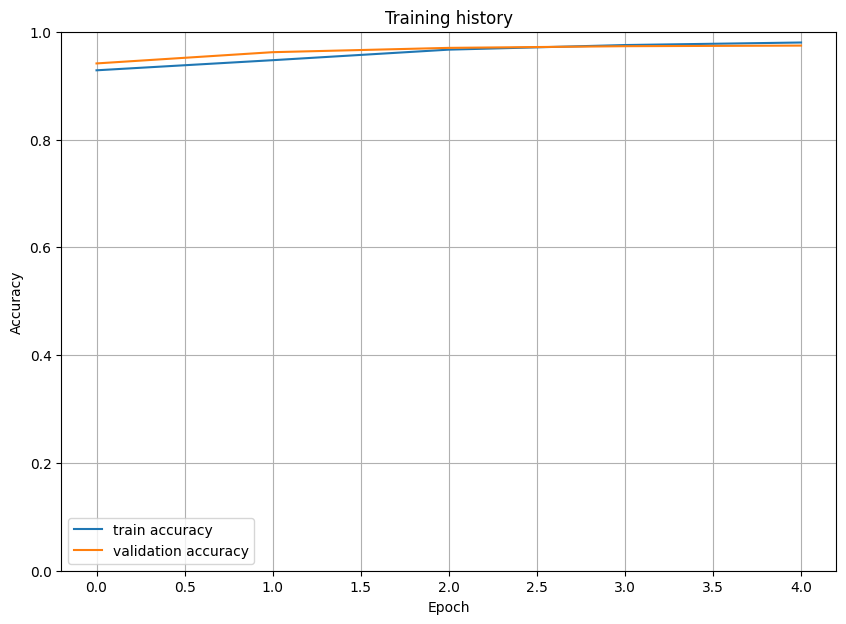

In [30]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10,7)
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);
plt.grid()

## Evaluation of the Model

In [34]:
# Loading pretrained model
model = BERTClass()
model.load_state_dict(torch.load(os.path.join(data_dir,"output_multi_class","best_model_state.pt")))
model = model.to(device)

In [35]:
# Evaluate the model using the test data
test_acc, test_loss = eval_model(test_data_loader, model, optimizer)

In [36]:
test_acc

0.9741637831603229

In [37]:
from sklearn.metrics import confusion_matrix, classification_report

In [44]:
import torch

def get_predictions(model, data_loader):
    model = model.eval()

    texts = []
    predictions = []
    prediction_probs = []
    target_values = []

    with torch.no_grad():
        for data in data_loader:
            texts = data["text"]
            ids = data["input_ids"].to(device, dtype=torch.long)
            mask = data["attention_mask"].to(device, dtype=torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data["targets"].to(device, dtype=torch.float)

            outputs = model(ids, mask, token_type_ids)
            _, preds = torch.max(outputs, dim=1)
            _, targ = torch.max(targets, dim=1)

            texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            target_values.extend(targ)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    target_values = torch.stack(target_values).cpu()

    return texts, predictions, prediction_probs, target_values

# Assuming `model` and `test_data_loader` are defined and `device` is set to 'cuda' if available
# Also assuming `target_list` is defined which contains the target class names
texts, predictions, prediction_probs, target_values = get_predictions(model, test_data_loader)

# Now we can convert to numpy arrays and use sklearn's classification_report
from sklearn.metrics import classification_report
print(classification_report(target_values.numpy(), predictions.numpy(), target_names=target_list))


              precision    recall  f1-score   support

       SDG_1       0.58      0.64      0.61       154
       SDG_2       0.75      0.70      0.72       170
       SDG_3       0.85      0.85      0.85       157
       SDG_4       0.88      0.80      0.84       191
       SDG_5       0.74      0.84      0.79       176
       SDG_6       0.74      0.81      0.77       156
       SDG_7       0.65      0.80      0.72       148
       SDG_8       0.48      0.44      0.46       142
       SDG_9       0.67      0.69      0.68       153
      SDG_10       0.66      0.58      0.62       174
      SDG_11       0.78      0.74      0.76       193
      SDG_12       0.76      0.68      0.72       194
      SDG_13       0.66      0.69      0.67       163
      SDG_14       0.93      0.88      0.90       157
      SDG_15       0.78      0.75      0.77       167
      SDG_16       0.94      0.96      0.95       164
      SDG_17       1.00      1.00      1.00       146

    accuracy              

In [45]:
import seaborn as sns
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True category')
    plt.xlabel('Predicted category');

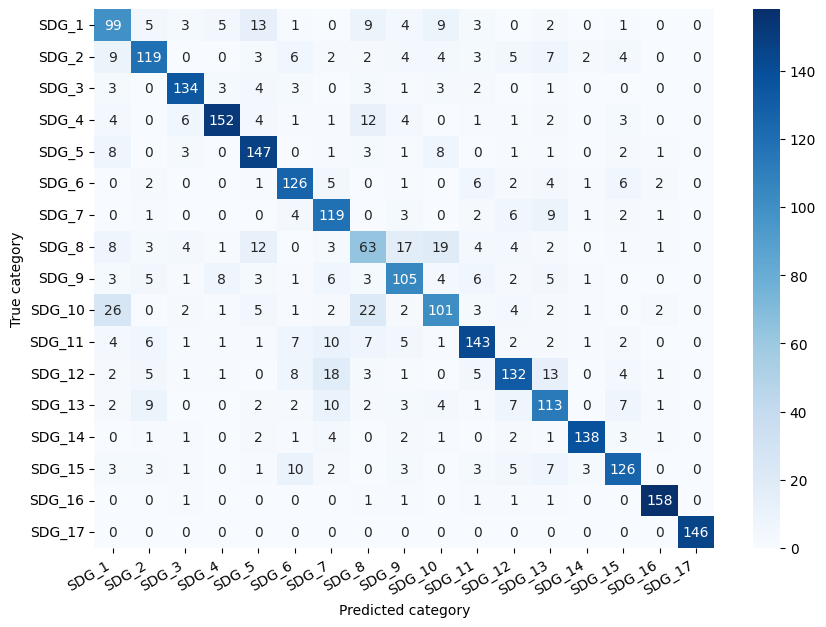

In [46]:
plt.rcParams["figure.figsize"] = (10,7)
cm = confusion_matrix(target_values, predictions)
df_cm = pd.DataFrame(cm, index=target_list, columns=target_list)
show_confusion_matrix(df_cm)

## Predicting on raw text

In [53]:
raw_text = "The Convention on the Conservation of Migratory Species of Wild Animals (CMS) has launched the first-ever comprehensive assessment of the state of the world’s migratory species. The report warns that almost half of the world’s migratory species are in decline and more than a fifth are threatened with extinction, including nearly all of CMS-listed fish. It provides a set of recommendations for priority action to save migratory animals."

In [54]:

encoded_text = tokenizer.encode_plus(
    raw_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=True,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
)

In [55]:
input_ids = encoded_text['input_ids'].to(device)
attention_mask = encoded_text['attention_mask'].to(device)
token_type_ids = encoded_text['token_type_ids'].to(device)
output = model(input_ids, attention_mask, token_type_ids)
_, prediction = torch.max(output, dim=1)

In [56]:

# Correctly predicted the topic of the paper: High energy physics
print(f'Text: {raw_text}')
print(f'Category: {target_list[prediction]}')

Text: The Convention on the Conservation of Migratory Species of Wild Animals (CMS) has launched the first-ever comprehensive assessment of the state of the world’s migratory species. The report warns that almost half of the world’s migratory species are in decline and more than a fifth are threatened with extinction, including nearly all of CMS-listed fish. It provides a set of recommendations for priority action to save migratory animals.
Category: SDG_15
